# Predição da Qualidade de Vinhos Portugueses

Neste estudo vamos analisar algumas propriedades químicas de amostras de vinhos portugueses <br>
Nosso objetivo é identificar a viabilidade da criação de um modelo preditivo, <br>
que seja capaz de classificar vinhos por nível de qualidade.

### Starting out - Aqui algumas bibliotecas necessárias para nossa análise

In [85]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
sns.set(color_codes=True)
sns.set_style('whitegrid')

### Loading & Shooting - Hora de carregar os dados em um Dataframe

In [86]:
df_wine = pd.read_csv("data/winequality.csv", sep=";")
df_size = len(df_wine)
print("Tamanho do Dataset:", df_size)
df_wine.head()

Tamanho do Dataset: 6497


,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,White,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,White,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,White,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,White,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,White,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [87]:
df_wine.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   type                  6497 non-null   object 
 1   fixed acidity         6497 non-null   float64
 2   volatile acidity      6497 non-null   float64
 3   citric acid           6497 non-null   float64
 4   residual sugar        6497 non-null   float64
 5   chlorides             6497 non-null   float64
 6   free sulfur dioxide   6497 non-null   float64
 7   total sulfur dioxide  6497 non-null   float64
 8   density               6497 non-null   float64
 9   pH                    6497 non-null   float64
 10  sulphates             6497 non-null   float64
 11  alcohol               6497 non-null   object 
 12  quality               6497 non-null   int64  
dtypes: float64(10), int64(1), object(2)
memory usage: 660.0+ KB


Olhando superficialmente o dataset vemos que se tratam de dados dados estruturados, as features são númericas com ponto flutuante, sendo apenas a coluna **type** do tipo **categórica**, vamos tratar dela mais a frente. 

### EDA - Exploratory Data Analysis

Antes de criarmos um modelo de predição precisamos explorar um pouco mais os dados que temos, é importante entender qual a distribuição das amostras de acordo com a feature target (ŷ) que pretendemos prever, além de identificar eventuais campos nulos que deverão ser tratados.

#### 1- Vamos verificar quantas amostras temos para cada nível de qualidade:

In [88]:
pd.DataFrame(df_wine["quality"]).groupby("quality")["quality"].aggregate(["count"]).sort_values("count", ascending=False)

,count
quality,
6,2836
5,2138
7,1079
4,216
8,193
3,30
9,5


Nossas amostras apresentam níveis de qualidade que vão de 3 à 9. No mundo real os dados quase nunca são balanceados, neste caso não é diferente. Para vinhos de qualidade mínima (**3**) temos apenas **30** amostras.  Vinhos de nota máxima (**9**) são 5 únicas amostras dentre outras 6497, ou seja, uma representatividade amostral muito irrisória.

In [89]:
print("Percentual de Amostras de Qualidade 6: {0:.2f}%".format((2836/df_size)*100))

Percentual de Amostras de Qualidade 6: 43.65%


A maior parte dos dados (cerca de **93%** das amostras) são sobre vinhos medianos (**5,6,7**). Nesse cenário uma simples função que faça ŷ = 6 acertaria 43,6% dos casos. Portanto veremos que acurácia não será a melhor forma de avaliar um modelo de predição para esse dataset.

#### 2 - Plotting to see better - Uma histograma pode falar melhor sobre onde se concentram nossos dados
Abaixo podemos ver que inclusive a maior concentração de amostras está entre os vinhos de qualidade 5 e 6. 

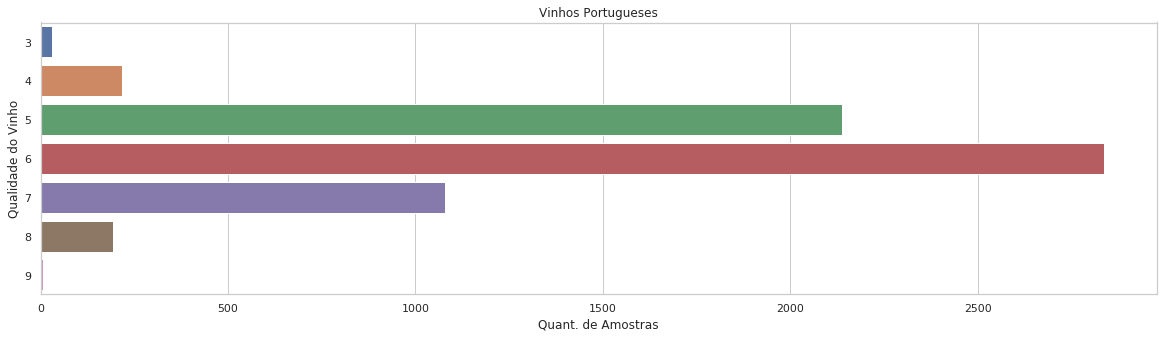

In [90]:
plt.figure(figsize=(20,5))

ax = sns.countplot(data=df_wine, y="quality")
ax.set(ylabel='Qualidade do Vinho', xlabel='Quant. de Amostras', title="Vinhos Portugueses")
plt.show()

O que acontece quando plotamos se o tipo vinho é branco ou vermelho?

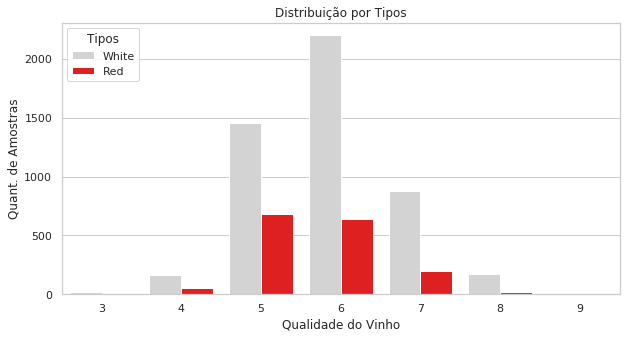

In [91]:
plt.figure(figsize=(10,5))

ax = sns.countplot(data=df_wine, x="quality", hue="type", palette=['lightgrey', 'red'])
ax.set(xlabel='Qualidade do Vinho', ylabel='Quant. de Amostras', title="Distribuição por Tipos")
plt.legend(title='Tipos')
plt.show()

Podemos então verificar que a maior parte das amostras são de vinhos do tipo branco. 
Abaixo podemos ver que das 35 ocorrências de qualidade 3 e 9, 25 são de vinhos brancos.

In [92]:
df_wine[(df_wine["quality"] == 3) | (df_wine["quality"] == 9)].groupby(["quality", "type"])["quality"].aggregate(["count"]).sort_values("count", ascending=False)

count
quality type        
3       White     20
        Red       10
9       White      5

#### 3 - Missing Values - Verificando se há valores nulos

In [93]:
df_wine.isnull().any()

type                    False
fixed acidity           False
volatile acidity        False
citric acid             False
residual sugar          False
chlorides               False
free sulfur dioxide     False
total sulfur dioxide    False
density                 False
pH                      False
sulphates               False
alcohol                 False
quality                 False
dtype: bool

Ótimo! Nenhum valor nulo, podemos seguir com os próximos passos!

#### 4 - Correlation Matrix - Verificando correlações 

Antes de seguirmos precisamos transformar a coluna categórica (**Type**) em numérica. Como trata-se de duas categorias podemos utilizar os valores 1 e 0 para vinhos brancos e tintos respectivamente. Caso houvessem mais de 2 tipos de vinho, a utilização de one-hot encoding seria necessária.

In [94]:
df_wine["type"] = np.where(df_wine["type"]=="White", 1, 0)

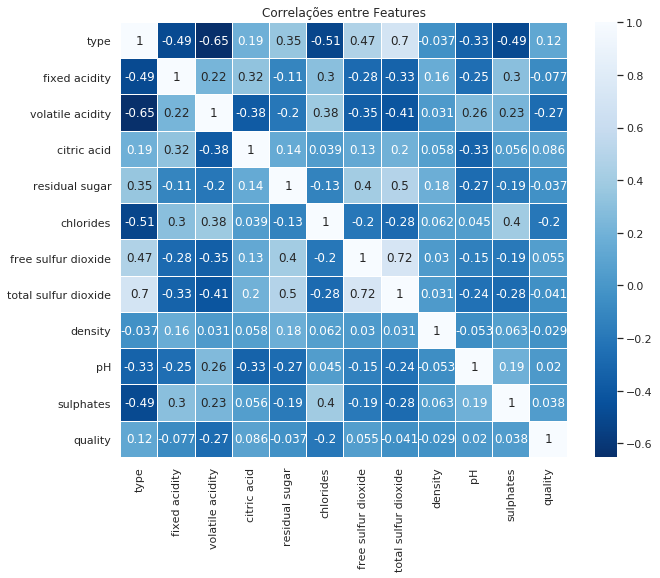

In [96]:
df_corr = df_wine.corr()
plt.figure(figsize=(10,8))
ax = sns.heatmap(df_corr, annot=True, cmap="Blues_r", linewidths=.1)
ax.set(title="Correlações entre Features")
plt.show()

Ao analisarmos as correlações entre colunas vemos que, apesar de duas pequenas correlações inversas com as colunas *chlorides* e *volatile acidity*, não existe nenhum atributo que correlacione diretamente com a qualidade do vinho.

Vale notar que existem algumas poucas correlações entre atributos, e um ponto muito interessante: muitas featuras possuem correlação alta (maior que 0.5) com o tipo do vinho, se o desafio fosse predizer o tipo do vinho teríamos mais chances de acertar. 

#### 5 - Top Features - Selecionando e identificando as Features que fazem acontecer 

In [98]:
# Algumas bibliotecas do sckit
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

#Aqui dividimos o dataframe em features e na target
features_name = list(df_wine.columns[:-2])
features_name

['type',
 'fixed acidity',
 'volatile acidity',
 'citric acid',
 'residual sugar',
 'chlorides',
 'free sulfur dioxide',
 'total sulfur dioxide',
 'density',
 'pH',
 'sulphates']

In [99]:
x_features = df_wine[features_name].to_numpy()
y_hat = df_wine[df_wine.columns[-1]].to_numpy()

In [100]:
print(x_features.shape, y_hat.shape)

(6497, 11) (6497,)


In [120]:
# Todo corrigir coluna com valores errados
#x_features[:,-1] = x_features[:,-1].astype(float)

In [152]:
rf_clf = RandomForestClassifier(random_state=42, n_estimators=100, max_depth=13)

In [153]:
#Treino
rf_clf.fit(x_features, y_hat)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=13, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [154]:
print("Score Treino")
print(rf_clf.score(x_features, y_hat))

Score Treino
0.9450515622595044


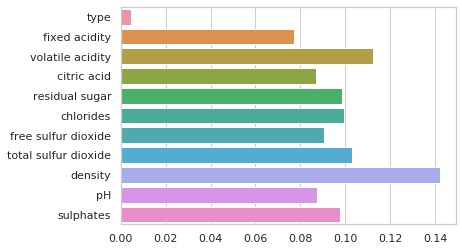

In [156]:
sns.barplot(rf_clf.feature_importances_, features_name);

In [157]:
# TODO: Verificar modelos alternativos com menos colunas
# TODO: UTILIZAR K-FOLD
# TODO: DEFINIR QUAL METRICA UTILIZAR